In [1]:
import pickle
import numpy as np
from math import *
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

In [29]:
# Parameters setup
Du = 1.0
Dv = 0.5
ff = 0.055
kk = 0.062

# Grid setup
m, n = 129, 129
h = 2

# Time steps
dt = 0.25
end_t = 200
time_steps = int(end_t/dt)
print(time_steps)
c = dt/(h*h)

800


In [30]:
# Initial condition
U = np.zeros((time_steps, m, n))
V = np.zeros((time_steps, m, n))
U[0][:, :] = 1
V[0][51:60, 51:70] = 1
V[0][61:80, 71:80] = 1

In [4]:
# Function to plot the contour of the 2D pattern of U[tu] and V[tv]
def plot_pattern(U, V, tu, tv, filled=True):
    
    # 2D meshgrid setup
    x = np.linspace(0, (n-1)*h, n)
    y = np.linspace(0, (m-1)*h, m)
    X, Y = np.meshgrid(x, y)
    
    # Countour plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    extent = [x[0], x[-1], y[0], y[-1]]
    levelsU = np.linspace(np.amin(U), np.amax(U), 20) 
    levelsV = np.linspace(np.amin(V), np.amax(V), 20)  

    if not filled and tu!=0 and tv!=0:
        csU = axes[0].contour(X, Y, U[tu], levels = levelsU, extent = extent, cmap=plt.cm.coolwarm)
        csV = axes[1].contour(X, Y, V[tv], levels = levelsV, extent = extent, cmap=plt.cm.coolwarm)        
    else:
        csU = axes[0].contourf(X, Y, U[tu], levels = levelsU, extent = extent, cmap=plt.cm.coolwarm)
        csV = axes[1].contourf(X, Y, V[tv], levels = levelsV, extent = extent, cmap=plt.cm.coolwarm)
    
    cbarU = fig.colorbar(csU, ax=axes[0], shrink=0.8)
    cbarV = fig.colorbar(csV, ax=axes[1], shrink=0.8)
    
    axes[0].set_title('U at n = %s, time = %.2f sec' % (tu, tu*dt), fontsize=16)
    axes[1].set_title('V at n = %s, time = %.2f sec' % (tu, tv*dt), fontsize=16)
    
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    
    fig.tight_layout()

    plt.show()

In [5]:
# Function to animate the contour plot of the 2D pattern of U, V
def animate_pattern(U, V, Nt, Nout):
    """
    Nt:   Total number of timesteps to animate
    Nout: Plot figure per Nout timesteps 
    """
    x = np.linspace(0, (n-1)*h, n)
    y = np.linspace(0, (m-1)*h, m)
    X, Y = np.meshgrid(x, y)

    fig, axes = plt.subplots(1, 2, figsize=(14,7))

    extent = [x[0], x[-1], y[0], y[-1]]
    levelsU = np.linspace(np.amin(U), np.amax(U), 20)
    levelsV = np.linspace(np.amin(V), np.amax(V), 20)

    csU = axes[0].contourf(X, Y, U[0], levels = levelsU, extent = extent, cmap=plt.cm.coolwarm)
    csV = axes[1].contourf(X, Y, V[0], levels = levelsV, extent = extent, cmap=plt.cm.coolwarm)

    cbarU = fig.colorbar(csU, ax=axes[0], shrink=0.8)
    cbarV = fig.colorbar(csV, ax=axes[1], shrink=0.8)

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    fig.tight_layout()


    def updatefig(i):
        axes[0].clear()
        axes[1].clear()

        axes[0].contourf(X, Y, U[i*Nout], levels = levelsU, extent = extent, cmap=plt.cm.coolwarm)
        axes[1].contourf(X, Y, V[i*Nout], levels = levelsV, extent = extent, cmap=plt.cm.coolwarm)

        axes[0].set_title('U at n = %s, time = %.2f sec' % (i*Nout, i*Nout*dt), fontsize=16)
        axes[1].set_title('V at n = %s, time = %.2f sec' % (i*Nout, i*Nout*dt), fontsize=16)


    ani = animation.FuncAnimation(fig, updatefig, frames=int(Nt/Nout), interval=200, blit=False)
    
    return ani 

In [6]:
# Function to animate the imshow plot of the 2D pattern of U, V
def animate_pattern_2(U, V, Nt, Nout):
    """
    Nt:   Total number of timesteps to animate
    Nout: Plot figure per Nout timesteps 
    """
    x = np.linspace(0, (n-1)*h, n)
    y = np.linspace(0, (m-1)*h, m)
    X, Y = np.meshgrid(x, y)

    fig, axes = plt.subplots(1, 2, figsize=(14,7))
    extent = [x[0], x[-1], y[0], y[-1]]

    imU = axes[0].imshow(U[0], origin='lower', extent = extent, animated=True)
    imV = axes[1].imshow(V[0], origin='lower', extent = extent, animated=True)
    cbarU = fig.colorbar(imU, ax=axes[0], shrink=0.8)
    cbarV = fig.colorbar(imV, ax=axes[1], shrink=0.8)
    axes[0].set_title('U at n = %s, time = %.2f sec' % (0, 0*dt), fontsize=16)
    axes[1].set_title('V at n = %s, time = %.2f sec' % (0, 0*dt), fontsize=16)
    # fig.tight_layout()
    

    def updatefig(i):
        global cbarU, cbarV
        cbarU.remove()
        cbarV.remove()

        axes[0].cla()
        axes[1].cla()

        imU = axes[0].imshow(U[i*Nout], origin='lower', extent = extent, animated=True)
        imV = axes[1].imshow(V[i*Nout], origin='lower', extent = extent, animated=True)
        cbarU = fig.colorbar(imU, ax=axes[0], shrink=0.8)
        cbarV = fig.colorbar(imV, ax=axes[1], shrink=0.8)
        axes[0].set_title('U at n = %s, time = %.2f sec' % (i*Nout, i*Nout*dt), fontsize=16)
        axes[1].set_title('V at n = %s, time = %.2f sec' % (i*Nout, i*Nout*dt), fontsize=16)
    #     fig.tight_layout()
        return imU, imV
    

    ani = animation.FuncAnimation(fig, updatefig, frames=int(Nt/Nout), interval=200, blit=True)
    
    return ani 

In [19]:
# Function to compute laplacian of a 2D matrix M with periodic boundary condition
def my_laplacian(M):
    return -4*M + np.roll(M, 1, axis=1) + np.roll(M, -1, axis=1) + np.roll(M, 1, axis=0) + np.roll(M, -1, axis=0)

In [31]:
# Generate pattern using own laplace function 
for i in range(1, time_steps):
#     U[i,:,:], V[i,:,:] = my_laplacian(U[i-1,:,:], V[i-1,:,:]) 
    U[i,:,:] = Du*c*my_laplacian(U[i-1,:,:])
    V[i,:,:] = Dv*c*my_laplacian(V[i-1,:,:])
    
    U[i,:,:] += -dt*np.multiply(U[i-1,:,:], np.square(V[i-1,:,:])) + dt*ff*(1-U[i-1,:,:]) + U[i-1,:,:]
    V[i,:,:] += dt*np.multiply(U[i-1,:,:], np.square(V[i-1,:,:])) - dt*(kk+ff)*V[i-1,:,:] + V[i-1,:,:]            

In [21]:
# Generate pattern using library laplace function 
for i in range(1, time_steps):
    U[i,:,:] = Du*c*ndimage.laplace(U[i-1,:,:], mode='wrap')
    V[i,:,:] = Dv*c*ndimage.laplace(V[i-1,:,:], mode='wrap')
    
    U[i,:,:] += -dt*np.multiply(U[i-1,:,:], np.square(V[i-1,:,:])) + dt*ff*(1-U[i-1,:,:]) + U[i-1,:,:]
    V[i,:,:] += dt*np.multiply(U[i-1,:,:], np.square(V[i-1,:,:])) - dt*(kk+ff)*V[i-1,:,:] + V[i-1,:,:]            

In [9]:
pickle.dump(U, open('U', 'wb'))
pickle.dump(V, open('V', 'wb'))

In [ ]:
Uread = pickle.load(open('U', 'rb'))
Vread = pickle.load(open('V', 'rb'))

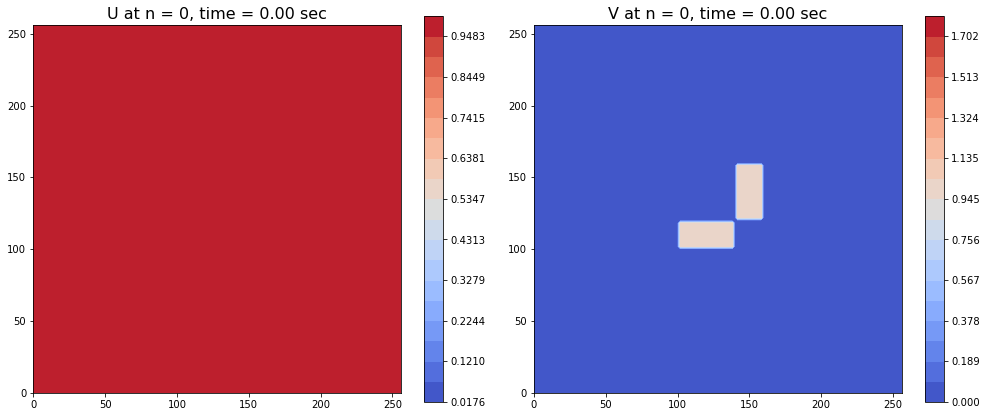

In [32]:
plot_pattern(U, V, 0, 0, filled=True)

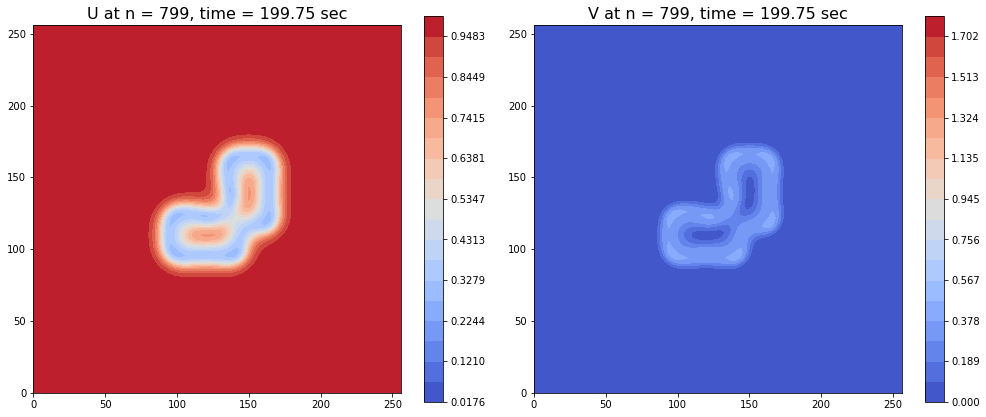

In [33]:
plot_pattern(U, V, time_steps-1, time_steps-1, filled=True)

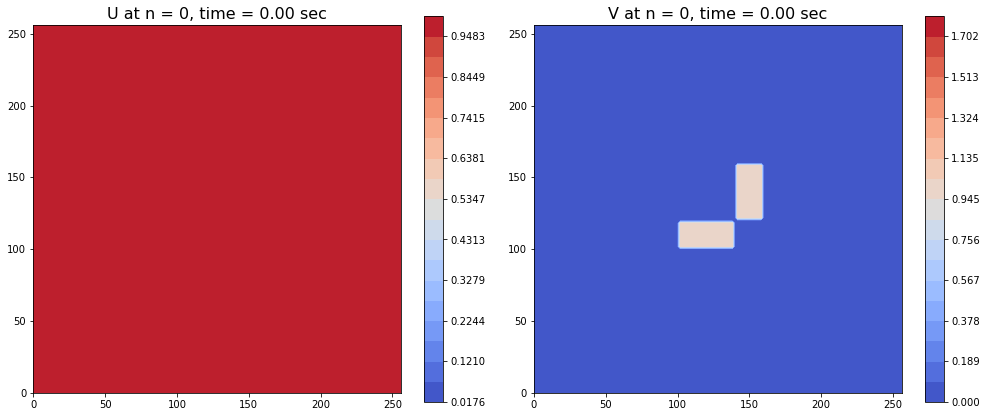

In [11]:
ani = animate_pattern(U, V, Nt=time_steps, Nout=100)
HTML(ani.to_html5_video()) 

In [ ]:
# for i in range(1, time_steps):
#     for j in range(m):
#         for k in range(n):
#             s1 = -4*U[i-1][j, k]
#             s2 = -4*V[i-1][j, k]
#             orth_neighbors = np.array([(j-1, k), (j+1, k), (j, k-1), (j, k+1)])
#             for jn, kn in orth_neighbors:
#                 if jn < 0: 
#                     jn += m
#                 if jn >= m: 
#                     jn -= m
#                 if kn < 0:
#                     kn += n
#                 if kn >= n:
#                     kn -= n
#                 s1 += U[i-1][jn, kn]
#                 s2 += V[i-1][jn, kn]
            
#             s1 *= Du*c
#             s2 *= Dv*c
            
#             s1 -= dt*U[i-1][j, k]*(V[i-1][j ,k]**2)
#             s2 += dt*U[i-1][j, k]*(V[i-1][j ,k]**2)
            
#             s1 += dt*ff*(1-U[i-1][j, k])
#             s2 -= dt*(kk+ff)*V[i-1][j, k]
            
#             s1 += U[i-1][j, k]
#             s2 += V[i-1][j, k]
            
#             U[i][j, k] = s1
#             V[i][j, k] = s2

In [14]:
x2 = np.reshape(np.arange(10), (2,5))
print(x2)

[[0 1 2 3 4]
 [5 6 7 8 9]]


In [17]:
print(np.roll(x2, 1, axis=1))

[[4 0 1 2 3]
 [9 5 6 7 8]]


In [18]:
print(np.roll(x2, 1, axis=0))

[[5 6 7 8 9]
 [0 1 2 3 4]]
